In [1]:
{-# LANGUAGE LambdaCase
    , RecordWildCards
    , TemplateHaskell
    , ScopedTypeVariables
    , RankNTypes
    , BangPatterns
    , StandaloneDeriving
    , UndecidableInstances
    , DataKinds
    , BlockArguments
    , KindSignatures
    , MagicHash #-}

Line 1: Unused LANGUAGE pragma
Found:
{-# LANGUAGE LambdaCase, RecordWildCards, TemplateHaskell, ScopedTypeVariables, RankNTypes, BangPatterns, StandaloneDeriving, UndecidableInstances, DataKinds, BlockArguments, KindSignatures, MagicHash #-}
Why not:
{-# LANGUAGE ScopedTypeVariables, RankNTypes, UndecidableInstances, DataKinds, BlockArguments #-}

In [2]:
import Graphics.Matplotlib
import IHaskell.Display
import qualified Data.Csv as CSV
import qualified Data.ByteString.Lazy as BL
import qualified Data.Vector as Vec
import qualified Data.Vector.Unboxed as UVec
import qualified Linear.V as V
import qualified Data.Vector.Algorithms.Intro as VecAlgI
import Data.Functor
import Data.Foldable
import Data.Function
import Data.Maybe
import Control.Monad.Identity
import qualified Control.Parallel.Strategies as Par
import Control.Monad
import qualified Statistics.Function as StatF
import Control.Lens
import qualified Statistics.Sample.Normalize as Stat
import qualified Statistics.Sample as Stat
import qualified Statistics.Function as Stat
import GHC.TypeLits (Nat, KnownNat, natVal')
import GHC.Exts (Proxy#, proxy#)

In [3]:
infixl 1 <&!>

x <&!> f = f <$!> x

In [4]:
putPlot :: Matplotlib -> IO DisplayData
putPlot p = do
    pic <- toSvg p
    return $ either error id (svg <$> pic)

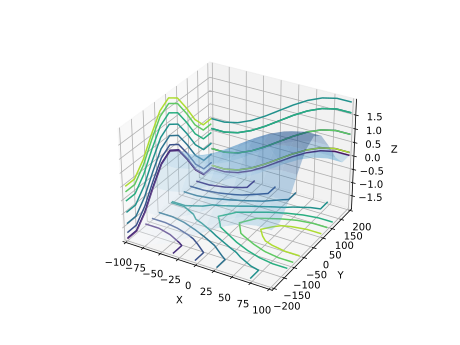

In [5]:
putPlot $ contourF (\a b -> sin (a*pi/180.0) + cos (b*pi/180.0)) (-100) 100 (-200) 200 10

In [6]:
data TD
    = TD
        { _klass :: Int
        , _alcohol, _malicAcid, _ash, _alcalinityOfAsh :: Double
        , _magnesium :: Double
        , _totalPhenols, _flavanoids, _nonflavanoidPhenols, _proanthocyanins, _colorIntensity, _hue, _dilutedWines :: Double
        , _proline :: Double
        }
    deriving (Show)

type Xs = V.V 13 Double

makeLenses ''TD
castTD
    :: ( Int
       , Double, Double, Double, Double
       , Double
       , Double, Double, Double, Double, Double, Double, Double
       , Double)
    -> (Int, Xs)
castTD
    ( _klass
    , _alcohol, _malicAcid, _ash, _alcalinityOfAsh
    , _magnesium, _totalPhenols, _flavanoids, _nonflavanoidPhenols, _proanthocyanins, _colorIntensity, _hue, _dilutedWines
    , _proline)
    = (_klass, fromJust $ V.fromVector $ Vec.fromList [_alcohol, _malicAcid, _ash, _alcalinityOfAsh, _magnesium, _totalPhenols, _flavanoids, _nonflavanoidPhenols, _proanthocyanins, _colorIntensity, _hue, _dilutedWines, _proline])

dfInit <- BL.readFile "wine.csv" <&> CSV.decode CSV.HasHeader <&> either error id <&> fmap castTD

dfY0 = fst <$> dfInit
dfXs = snd <$> dfInit

badPrintHead :: (Show a) => Vec.Vector a -> Vec.Vector Xs -> IO ()
badPrintHead dfy dfx = forM_ (Vec.take 5 $ Vec.zip dfy dfx) print

badPrintHead dfY0 dfXs
putStr "===========\nRows count:"
totalLen = Vec.length dfXs
print totalLen

(3,V {toVector = [12.87,4.61,2.48,21.5,86.0,1.7,0.65,0.47,0.86,7.65,0.54,1.86,625.0]})
(2,V {toVector = [13.34,0.94,2.36,17.0,110.0,2.53,1.3,0.55,0.42,3.17,1.02,1.93,750.0]})
(2,V {toVector = [12.29,2.83,2.22,18.0,88.0,2.45,2.25,0.25,1.99,2.15,1.15,3.3,290.0]})
(1,V {toVector = [13.2,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.4,1050.0]})
(2,V {toVector = [13.05,5.8,2.13,21.5,86.0,2.62,2.65,0.3,2.01,2.6,0.73,3.1,380.0]})

Rows count:

178

In [7]:
transposeR :: Vec.Vector Xs -> V.V 13 (Vec.Vector Double)
transposeR x =
    fromJust $ V.fromVector $
        Vec.fromList
            [ (\c -> V.toVector c Vec.! i) <$> x
            | i <- [0..12]
            ]

transposeL :: V.V 13 (Vec.Vector Double) -> Vec.Vector Xs
transposeL x =
    let v = V.toVector x in
    let l = Vec.length $ Vec.head v in
    fromJust . V.fromVector <$>
    foldl' (Vec.zipWith Vec.snoc) (Vec.replicate l Vec.empty) v

-- test invariant
unless (transposeL (transposeR dfXs) == dfXs) $ error "ooops"

In [8]:
StatF.minMax $ fromIntegral <$> dfY0

(1.0,3.0)

In [9]:
bool2Int = \case
    True -> 1.0
    False -> 0.0
features = (\a -> (bool2Int $ a == 1, bool2Int $ a == 2, bool2Int $ a == 3)) <$> dfY0
Vec.take 10 features

[(0.0,0.0,1.0),(0.0,1.0,0.0),(0.0,1.0,0.0),(1.0,0.0,0.0),(0.0,1.0,0.0),(0.0,1.0,0.0),(0.0,1.0,0.0),(1.0,0.0,0.0),(0.0,0.0,1.0),(0.0,0.0,1.0)]

In [37]:
standardize :: Vec.Vector Double -> Vec.Vector Double
standardize v =
    let m = Stat.mean v in
    let d = sqrt $ Stat.varianceUnbiased v in
    v <&> (\x -> (x - m) / d)

In [38]:
(\v ->
    let my = standardize v in
    let ex = fromJust (Stat.standardize v) in
    unless (my == ex) $ error $ "std bad " ++ show (Vec.zip ex my)) $
    Vec.fromList [1, 2, 10, 30, -0.1]

In [12]:
let dfXs' = transposeL $ (\s -> fromJust . Stat.standardize <$> s) $ transposeR dfXs
badPrintHead features dfXs'

((0.0,0.0,1.0),V {toVector = [-0.16089394890802267,2.035232178001052,0.41365272183603347,0.6003946382111737,-0.9621277013196957,-0.9508849760007656,-1.3808456427426943,0.8689687810542107,-1.276994074991414,1.1180286907153598,-1.8263401954075402,-1.0587260937670668,-0.3870764220724865]})
((0.0,1.0,0.0),V {toVector = [0.418047460367033,-1.2499245332266598,-2.3754314719298262e-2,-0.7470867437085522,0.7182523232255782,0.3753091744226562,-0.7301029403463367,1.51177997285743,-2.04574254504005,-0.814433588614435,0.2736585435317145,-0.9601332153788932,9.865569498367636e-3]})
((0.0,1.0,0.0),V {toVector = [-0.8753322837580905,0.441886416152189,-0.5340625240338503,-0.4476464366152798,-0.8220960326075896,0.24748323221317034,0.22098254777141654,-0.8987619964046403,0.6972917685425828,-1.2544138397118436,0.8424082019944288,0.9694702616467944,-1.4508809594823757]})
((1.0,0.0,0.0),V {toVector = [0.24559682781701594,-0.4980085557249491,-0.8256672150707381,-2.4838405248495325,1.8093979665047392e-2,0.5670

In [13]:
distEuclid a b = sqrt $ sum $ (a - b) ^ 2
distManhattan a b = sum $ abs $ a - b
distChebyshev a b = maximum $ abs $ a - b

In [14]:
kernalize f u = if abs u > 1 then 0 else f u
kernUniform = const 0.5
kernTriangular = kernalize \u -> 1 - abs u
kernEpanechnikov = kernalize \u -> 3 / 4 * (1 - u ^ 2)
kernQuartic = kernalize \u -> 15 / 16 * (1 - u ^ 2) ^ 2

In [15]:
broad :: forall n. KnownNat n => Double -> V.V n Double
broad a = fromJust $ V.fromVector $
    Vec.replicate (fromInteger $ natVal' (proxy# :: Proxy# n)) a

features' :: Vec.Vector (V.V 3 Double)
features' = features <&> \(x, y, z) -> fromJust $ V.fromVector $ Vec.fromList [x, y, z]

nadarWatCrossValidate
    :: forall (n :: Nat). KnownNat n
    => Vec.Vector (V.V n Double)
    -> Vec.Vector Xs
    -> (Xs -> Xs -> Double)
    -> (Double -> Double)
    -> (Xs -> Double)
    -> Vec.Vector (V.V n Double)
nadarWatCrossValidate ys xs dist kern wnd =
    let
        step x =
            let
                xwnd :: Double
                !xwnd = wnd x
                ks :: Vec.Vector Double
                !ks = (\xi -> if x == xi then 0 else kern $ dist x xi / xwnd) <$!> xs
            in sum (Vec.zipWith (\k y -> broad k * y) ks ys) / broad (sum ks)
    in Vec.fromList $ Par.parMap Par.rdeepseq step $ Vec.toList xs

In [16]:
argPred :: Foldable f => (a -> a -> Bool) -> f a -> Maybe (a, Int)
argPred p v =
    fst $ foldl'
        (\(!a, !i) !c ->
            case a of
                Nothing -> (Just (c, i), i + 1)
                Just (!b, !ib) ->
                    if p c b
                    then (Just (c,  i), i + 1)
                    else (Just (b, ib), i + 1))
        (Nothing, 0)
        v

In [17]:
calcF :: Vec.Vector (V.V 3 Double) -> Double
calcF validated =
    Stat.mean $ Vec.fromList [0..Vec.length dfXs - 1] <&!> \(r :: Int) ->
        Stat.mean $ Vec.fromList [0..2] <&> \(i :: Int) ->
            let
                !truth = dfY0 Vec.! r == i + 1
                !ours = maybe undefined snd (argPred (>) (V.toVector $ validated Vec.! r)) == i
                !tp = bool2Int $ truth == ours && ours
                !tn = bool2Int $ truth == ours && not ours
                !fp = bool2Int $ truth /= ours && ours
                !fn = bool2Int $ truth /= ours && not ours in
            if tp + fn + fp == 0
            then 1
            else 2 * tp / (2 * tp + fn + fp)

In [18]:
dSqrt = sqrt $ fromIntegral totalLen

In [19]:
wndWithSize :: (Xs -> Xs -> Double) -> Int -> (String, Xs -> Double)
wndWithSize dist n = ("knn " ++ show n, \x ->
   Vec.modify VecAlgI.sort (dist x <$> dfXs') Vec.! n)
wndFrame = [1..ceiling dSqrt + 1]

In [20]:
nadarWatCrossValidate' = nadarWatCrossValidate features' dfXs'

findMaxDist df = maximum [df x y | x <- toList dfXs', y <- toList dfXs']
findMaxDistInt df = let md = findMaxDist df in (\x -> x * md / dSqrt) <$> [0..dSqrt]

fillAllParams ((ds, df), (ks, kf)) =
    let
        constWindowSizes = findMaxDistInt df
    in
        [ ((ds, df), (ks, kf), wnd)
        | wnd <- ((\n -> ("wnd " ++ show n, const n)) <$> constWindowSizes) ++ (wndWithSize df <$> wndFrame)
        ]

params =
    [ (dist, kernel)
    | dist <- [("euclid", distEuclid), ("manhattan", distManhattan), ("chebyshev", distChebyshev)]
    , kernel <- [("uniform", kernUniform), ("triangular", kernTriangular), ("epanechnikov", kernEpanechnikov), ("quartic", kernQuartic)]
    ] >>= fillAllParams

allParamsApplied = params <&> \((ds, df), (ks, kf), (ws, wf)) ->
    (calcF $! nadarWatCrossValidate' df kf wf, ds, ks, ws, df, kf, wf)

In [21]:
answer = fst $ fromJust $ argPred ((>) `on` (^. _1)) allParamsApplied
showAnswer = let (a, b, c, d, _, _, _) = answer in (a, b, c, d)
bestDist = answer ^. _5
bestKern = answer ^. _6
showAnswer

(0.9850187265917604,"euclid","triangular","wnd 5.027840014074431")

# constant window size

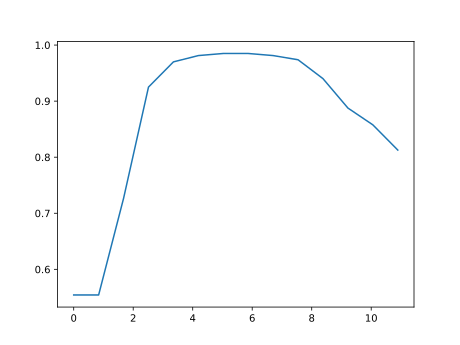

In [22]:
curValidateWindowCWS = calcF . nadarWatCrossValidate' bestDist bestKern
putPlot $ lineF (curValidateWindowCWS . const) $ findMaxDistInt bestDist

# knn

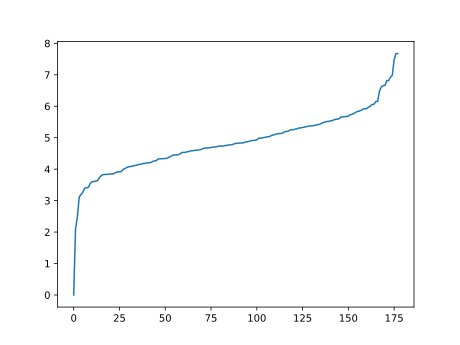

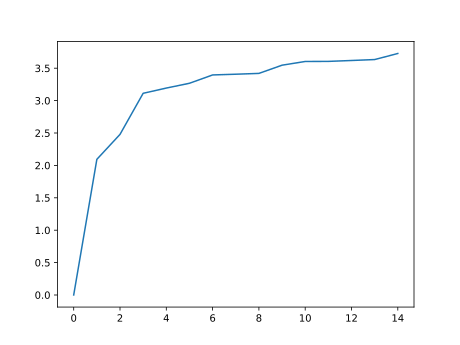

In [64]:
drawKnn = putPlot . lineF (\x -> snd (wndWithSize bestDist x) (dfXs' Vec.! 1))
drawKnn [0..Vec.length dfXs' - 1]
drawKnn [0..ceiling $ sqrt (fromIntegral (Vec.length dfXs') - 1 :: Double)]

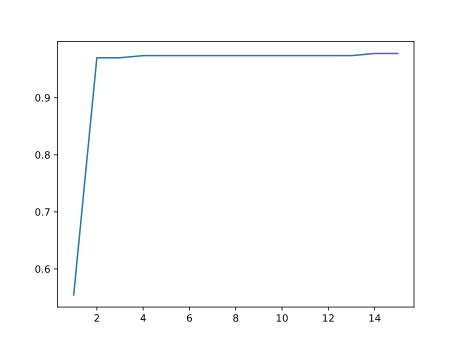

0.9737827715355806

In [63]:
curValidateWindowKNN = calcF . nadarWatCrossValidate' bestDist bestKern
putPlot $ lineF (curValidateWindowKNN . snd . wndWithSize bestDist) wndFrame

curValidateWindowKNN $ snd $ wndWithSize bestDist 8

In [65]:
maximum $ bestDist (dfXs' Vec.! 1) <$> dfXs'

7.677669662253651

максимальное расстояние как раз на ровном участке, поэтому мы и держимся около 1

In [25]:
forM_ (nadarWatCrossValidate' bestDist bestKern (answer ^. _7)) \x -> do
    print $ V.toVector x <&> \i -> fromIntegral (round $ i * 10 :: Int) / (10 :: Double)

[0.0,0.1,0.9]
[0.2,0.5,0.3]
[0.3,0.7,0.0]
[0.7,0.3,0.0]
[0.2,0.7,0.1]
[0.3,0.7,0.0]
[0.1,0.8,0.1]
[0.5,0.4,0.1]
[0.0,0.0,1.0]
[0.0,0.3,0.7]
[0.0,0.1,0.9]
[0.1,0.8,0.1]
[0.1,0.4,0.5]
[0.1,0.7,0.2]
[0.0,0.1,0.9]
[0.9,0.1,0.0]
[1.0,0.0,0.0]
[0.3,0.6,0.0]
[0.3,0.6,0.1]
[0.8,0.2,0.0]
[0.0,0.8,0.2]
[0.0,0.1,0.9]
[0.0,0.3,0.7]
[0.9,0.1,0.0]
[0.2,0.7,0.1]
[0.0,0.1,0.9]
[0.0,0.0,1.0]
[0.3,0.6,0.1]
[0.1,0.8,0.1]
[0.9,0.1,0.0]
[0.9,0.1,0.0]
[0.0,0.0,1.0]
[0.0,0.3,0.7]
[0.0,0.5,0.5]
[0.0,0.3,0.7]
[0.0,0.2,0.8]
[0.1,0.1,0.8]
[0.0,0.7,0.2]
[0.3,0.7,0.0]
[0.0,0.3,0.6]
[0.5,0.5,0.0]
[0.0,0.3,0.7]
[0.6,0.4,0.0]
[1.0,0.0,0.0]
[0.0,0.5,0.5]
[0.0,0.1,0.8]
[0.7,0.3,0.0]
[0.1,0.8,0.1]
[0.0,0.5,0.4]
[0.9,0.1,0.0]
[0.1,0.4,0.6]
[1.0,0.0,0.0]
[0.1,0.3,0.6]
[0.9,0.1,0.0]
[0.8,0.2,0.0]
[0.7,0.3,0.1]
[0.1,0.7,0.2]
[0.0,0.1,0.9]
[0.1,0.2,0.7]
[0.1,0.9,0.0]
[0.0,0.3,0.7]
[0.1,0.6,0.3]
[0.0,0.0,0.9]
[0.1,0.6,0.2]
[0.9,0.1,0.0]
[0.9,0.0,0.0]
[0.1,0.7,0.2]
[0.5,0.5,0.0]
[0.0,0.3,0.7]
[0.1,0.7,0.1]
[0.0,0.7,0.3]
[1.0,0

In [26]:
print $ findMaxDist bestDist
forM_ (Vec.modify VecAlgI.sort (bestDist (dfXs' Vec.! 0) <$> dfXs')) \i -> do
    print i

11.179958739325546

0.0
1.5749820437230413
1.7293380276909185
1.7538256640610854
2.046141708054056
2.049377499295543
2.0641348249419926
2.0941058573276354
2.1141193826406264
2.357348272666802
2.422138928285673
2.47711974096017
2.5007261468995905
2.5323554045448287
2.565124704194788
2.567752389334106
2.6666330912228435
2.679433966948072
2.6955504365098455
2.7386378436879855
2.744248941935735
2.7496874265042197
2.7552913310788267
2.778893670352365
2.8011984731395536
2.8732910597412262
2.9356216808252524
2.988257327366384
3.0008959424093056
3.001175005105498
3.034035003179575
3.0970153908615092
3.1055778087708354
3.1115610816106534
3.1403670719674954
3.2043590857900943
3.2081534092326023
3.211392592540837
3.266322500930151
3.3062800447391156
3.45398970332856
3.503066604183604
3.5286076163778635
3.6500989149377014
3.737864321496655
3.901675749391338
4.060314022739023
4.1335798511697135
4.341843357519492
4.390555577030575
4.420789461767131
4.421990939665848
4.423974616778013
4.44936197717505
4.486219413145422
